In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
import pandas as pd
import numpy as np
import json
import math

from shapely.geometry import box, Point, LineString
from heapq import heappush, heappop
from itertools import count
from rtree import index

In [2]:
place_name = "Singapore, Central, Singapore"
# G = ox.graph_from_place(place_name, network_type='drive')
# ox.save_load.save_graphml(G, filename='Singapore_drive.graphml', folder=None, gephi=False)

graph = ox.save_load.load_graphml(filename="Singapore_drive.graphml", folder=None)

# Stores nodes and edges along with other attributes
type(graph)

networkx.classes.multidigraph.MultiDiGraph

In [3]:
nodes, edges = ox.graph_to_gdfs(graph, nodes=True, edges=True)

In [4]:
def process_speed_band(df):
    
    # Define Locations
    def truncate(number, digits) -> float:
        stepper = 10.0 ** digits
        return math.trunc(stepper * number) / stepper
    
    location = df['Location'].values
    i = 0
    
    for loc in location:
        x1, y1, x2, y2 = [float(n) for n in loc.split(' ')]
        
        x1 = truncate(x1, 7)
        y1 = truncate(y1, 7)
        x2 = truncate(x2, 7)
        y2 = truncate(y2, 7)
        
        if y1 < y2:
            bottom = y1
            top = y2
        else:
            bottom = y2
            top = y1
            
        if x1 < x2:
            left = x1
            right = x2
        else:
            left = x2
            right = x1
        
        df['Location'].values[i] = (left, bottom, right, top)
        i += 1 
    
    # Process maximum speeds
    i = 0
    for x in df['SpeedBand']:
        if x == 0:
            df['MaximumSpeed'][i] = '50'
        i += 1 

In [5]:
def process_edges(edges, speed_bands):
    # Remove null, list, and convert to int ---> maxspeed (km/hr)
    edges['maxspeed'].fillna('40', inplace=True)

    i = 0
    for x in edges['maxspeed']:
        if type(x) == list:
            edges['maxspeed'][i] = max(x)
        i += 1    

    edges['maxspeed'] = edges['maxspeed'].astype(int)
    

    # Define free-flow time t(u,v) in sec
    travel_time = []
    for l,s in zip(edges['length'], edges['maxspeed']):
        t = (3600*l)/(1000*s)
        travel_time.append(t)

    edges['travel_time'] = travel_time
    
    
    # Define Location    
    location = edges['geometry'].values
    i = 0
    Location = []
    
    for loc in location:        
        x1 = loc.xy[1][-1]
        y1 = loc.xy[0][-1]
        x2 = loc.xy[1][0]
        y2 = loc.xy[0][0]
        
        if y1 < y2:
            bottom = y1
            top = y2
        else:
            bottom = y2
            top = y1
            
        if x1 < x2:
            left = x1
            right = x2
        else:
            left = x2
            right = x1
        
        Location.append((left, bottom, right, top))
        i += 1 
        
    edges['Location'] = Location
    
    
    # Define observed_speed using speedband dataset    
        # key: maximum speed ,value: location
    idx = index.Index()
    Location = speed_bands['Location']
    Speed = speed_bands['MaximumSpeed']

    for speed, loc in zip(Speed, Location):
        idx.insert(int(speed), loc)
    
        # Find intersections
    observed_speed = []
    Location = edges['Location']

    for loc in Location:
        max_speeds = list(idx.intersection(loc))

        if len(max_speeds) == 0: # edge didn't intersect with any speed band
            observed_speed.append(70)
        else:
            observed_speed.append(sum(max_speeds)/len(max_speeds))  

    edges['observed_speed'] = observed_speed
    

    # Define BPR heuristic for each road link
    heuristic = [time * (1 + 0.15*(flow/capacity)**4) for time,flow,capacity in zip(edges['travel_time'],edges['observed_speed'],edges['maxspeed'])]
    edges['bpr'] = heuristic
    
    
    # Drop unnecessary columns
    edges.drop(['lanes','bridge','tunnel','ref','junction','access','service','geometry','width'], axis=1, inplace=True)
    
    
#     # Remove null and convert to int ---> width (m)
#     edges['width'].fillna('3', inplace=True)
#     edges['width'] = edges['width'].astype(int)
    
#     # Define density of cars on the road (area of road/area of car)
#     density = [math.floor((l*w*1000000000)/5885775)for l,w in zip(edges['length'],edges['width'])]
#     edges['density'] = density

In [6]:
f = open("../Traffic speed bands/Fri Feb 14 09_06_16 2020.json", "r").read()
x = json.loads(f)

speed_bands = pd.DataFrame.from_dict(x, orient='columns')
process_speed_band(speed_bands)
speed_bands.head()

/home/orionstar25/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,LinkID,Location,MaximumSpeed,MinimumSpeed,RoadCategory,RoadName,SpeedBand
0,103000000,"(1.316684, 103.8525988, 1.3170142, 103.8529805)",29,20,E,KENT ROAD,3
1,103000010,"(1.3166507, 103.8402256, 1.3169124, 103.841023)",29,20,E,BUCKLEY ROAD,3
2,103000011,"(1.3166507, 103.8402256, 1.3169124, 103.841023)",29,20,E,BUCKLEY ROAD,3
3,103000014,"(1.3180211, 103.8470026, 1.3186726, 103.8471139)",39,30,E,SHREWSBURY ROAD,4
4,103000015,"(1.3180211, 103.8470026, 1.3186726, 103.8471139)",49,40,E,SHREWSBURY ROAD,5


In [7]:
process_edges(edges, speed_bands)
edges.head()

/home/orionstar25/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,u,v,key,osmid,oneway,name,highway,maxspeed,length,width,travel_time,Location,observed_speed,bpr
0,1820000257,1865254946,0,174765824,True,Tampines Avenue 8,tertiary,60,14.248,NaN,0.85488,"(1.3565805, 103.9326163, 1.3566943, 103.9326752)",31.5,0.864622
1,1820000257,4662056865,0,587044201,True,Tampines Avenue 5,primary,60,27.282,NaN,1.63692,"(1.3565805, 103.9323996, 1.3566955, 103.9326163)",31.5,1.655573
2,3874553858,6995781882,0,384254693,False,Fidelio Street,tertiary,40,20.740,NaN,1.86660,"(1.3191823, 103.9212368, 1.3192215, 103.9214192)",34.0,2.012757
3,3874553858,3874553861,0,384254631,True,Fidelio Street,tertiary,40,15.191,NaN,1.36719,"(1.3191111, 103.9211207, 1.3191823, 103.9212368)",34.0,1.474242
4,1820000259,245190289,0,170861145,True,Tampines Avenue 8,tertiary,60,13.573,NaN,0.81438,"(1.3565404, 103.9326858, 1.3566471, 103.9327451)",31.5,0.823660


In [8]:
G = ox.gdfs_to_graph(nodes, edges)

### Finding shortest route between centroid of map and another point

In [10]:
# Boundary Box of entire area
bbox = box(*edges.unary_union.bounds)
orig_point = bbox.centroid
print(orig_point)

POINT (103.8228094 1.35161845)


In [11]:
target_point = nodes[nodes['osmid'] == 1820000257].geometry.values[0]
print(target_point)

POINT (103.9326163 1.3565805)


In [12]:
orig_xy = (orig_point.y, orig_point.x)
target_xy = (target_point.y, target_point.x)

In [13]:
def find_nearest_nodes(source, dist, G):
    # Create a bounding box around source of min distance in all directions
    (north, south, east, west) = ox.bbox_from_point(point=source, distance=dist)
    
    # Create truncated graph from box
    small_graph = ox.truncate_graph_bbox(G, north, south, east, west)
    
    # Get all nodes inside the bbox --> candidate destinations
    nodes = ox.graph_to_gdfs(small_graph, nodes=True, edges=False)
    candidate_dest = nodes['osmid'].tolist()
    
    return candidate_dest  


In [14]:
# Max distance for walking is 720m (10 min * 1.2 m/s)
# Find all nodes within 720 m from starting point (target_xy) ---> candidate destinations

candidate_dest = find_nearest_nodes(target_xy, 720, G)
candidate_dest

[1820000257,
 1820026113,
 1820000259,
 4670008836,
 4670008837,
 4670008838,
 4670008840,
 4670008842,
 4670008843,
 395227148,
 4670008845,
 1820000270,
 1820026124,
 395227158,
 5175554838,
 5175554839,
 5175554840,
 5175554842,
 2487509277,
 243686688,
 1865254946,
 1865254947,
 395227170,
 395227172,
 1820000293,
 4661984546,
 5266964774,
 1819975128,
 5266964778,
 4661984557,
 5266964781,
 4663363888,
 4600208435,
 6244901458,
 2487509332,
 6244901462,
 1820026216,
 3551042921,
 3551042920,
 4574348136,
 4574348137,
 4668456813,
 1820026224,
 7013732721,
 7013732724,
 7013732725,
 627791479,
 1820026231,
 7013732727,
 7013732730,
 7013732733,
 4663372158,
 5175554811,
 4663372159,
 4663372160,
 1820054658,
 1820000389,
 1820026248,
 245190289,
 1820054679,
 1831417495,
 1831417498,
 4662056861,
 1820026269,
 992571805,
 4662056865,
 992571815,
 1831390121,
 1819975084,
 1819975094,
 7011940535,
 1819975354,
 4660426171,
 7011940540,
 4660426172,
 243686592,
 1820054720,
 18200263

In [15]:
orig_node = ox.get_nearest_node(G, orig_xy, method='euclidean')
print(orig_node)

5698333646


In [24]:
def bureau_of_public_road(edge):
    # t(u,v) in sec
    time = edge.get('travel_time')
    
    # c(u,v)
    capacity = edge.get('maxspeed')
    
    # f(u,v)
    flow = 30 ## add speedband data
    
    # BPR
    h = time * (1 + 0.15*(flow/capacity)**4)
    return h

In [25]:
"""
Returns a list of nodes in a shortest path between source and target 
using the A* ("A-star") algorithm.
"""

def a_star(G, source, target, heuristic=None, weight='length'):
    
    if source not in G or target not in G:
        msg = 'Either source {} or target {} is not in G'
        raise nx.NodeNotFound(msg.format(source, target))

    if heuristic is None:
        # The default heuristic is h=0
        def heuristic(u, v):
            return 0

    push = heappush
    pop = heappop

    # The queue stores priority, node, cost to reach, and parent.
    # Uses Python heapq to keep in priority order.
    # Add a counter to the queue to prevent the underlying heap from
    # attempting to compare the nodes themselves. The hash breaks ties in the
    # priority and is guaranteed unique for all nodes in the graph.
    c = count()
    queue = [(0, next(c), source, 0, None)]

    # Maps enqueued nodes to distance of discovered paths and the
    # computed heuristics to target. We avoid computing the heuristics
    # more than once and inserting the node into the queue too many times.
    enqueued = {}
    # Maps explored nodes to parent closest to the source.
    explored = {}

    while queue:
        flag = 0
        # Pop the smallest item from queue.
        f, _, curnode, g, parent = pop(queue)

        if curnode == target:
            path = [curnode]
            node = parent
            while node is not None:
                path.append(node)
                node = explored[node]
            path.reverse()
            return path,f # Return route and travelled time of route 

        if curnode in explored:
            # Do not override the parent of starting node
            if explored[curnode] is None:
                continue

            # Skip bad paths that were enqueued before finding a better one
            for key in range(0,3):
                if (curnode, key) in enqueued:
                    qcost, h = enqueued[(curnode,key)]
                    if qcost < g:
                        flag = 1
                        break
            
            if flag == 1:
                continue

        explored[curnode] = parent

        for neighbor, w in G[curnode].items():
            for key, edge in w.items():
                if (neighbor,key) in enqueued:
                    qcost, h = enqueued[(neighbor,key)]
                    # if qcost <= g, a less costly path from the
                    # neighbor to the source was already determined.
                    # Therefore, we won't attempt to push this neighbor to the queue
                    if qcost <= g:
                        continue
                else:
                    h = heuristic(edge)

                enqueued[(neighbor,key)] = g, h
                push(queue, (g + h, next(c), neighbor, g, curnode))

    raise nx.NetworkXNoPath("Node %s not reachable from %s" % (target, source))


In [39]:
# Perform A* for all paths
min_time = float('inf')
final_route = list()

for candidate_node in candidate_dest:    
    route, time = a_star(G, orig_node, candidate_node, bureau_of_public_road)
    # Choose one with least travel time
    if time < min_time:
        final_route = route
        min_time = time

# Time to reach destination in min
print(min_time)

0.006906487850300468


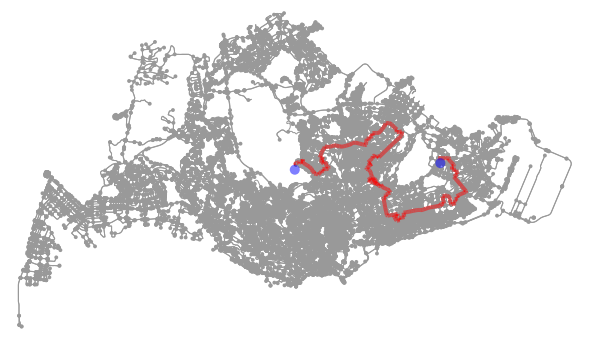

<Figure size 432x288 with 0 Axes>

In [19]:
fig, ax = ox.plot_graph_route(G, final_route, origin_point=orig_xy, destination_point=target_xy)
plt.tight_layout()

In [23]:
# Perform dijkstra with bpr for all paths
min_length = float('inf')

for candidate_node in candidate_dest:    
    length = nx.shortest_path_length(G, source=orig_node, target=candidate_node, weight='bpr')
    # Choose one with least travel time
    if length < min_time:
        route = nx.shortest_path(G, source=orig_node, target=candidate_node, weight='bpr')
        min_length = length
        
print(min_length)

220.53631803055853


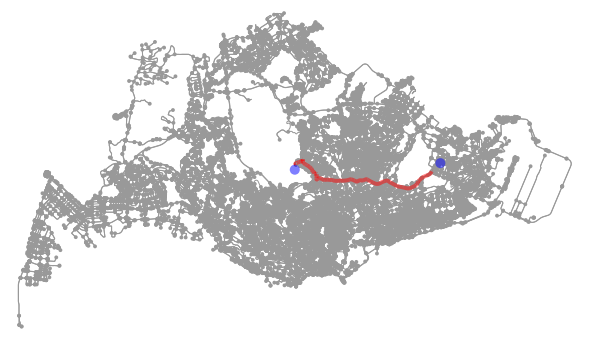

<Figure size 432x288 with 0 Axes>

In [22]:
fig, ax = ox.plot_graph_route(G, route, origin_point=orig_xy, destination_point=target_xy)
plt.tight_layout()